## Pregunta de Negocio - Analistes de Finances i Risc Crediticio

> ¿Qué **umbrales de saldo** podrían indicar mayor **riesgo de morosidad**?


## Librerías y Carga de datos

In [84]:
"""Librerías que pueden ser necesarias"""

# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualización de diagramas de "treemap"

# Procesado y análisis
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Paleta de colores oficial
custom_palette = [ "#2CCED1", "#5F6F81", "#AABBC8", "#DCE3EA", "#2E2F36"]

In [56]:
df = pd.read_csv("../Data/df_250519.csv")

## KPIs

1. SALDO MEDIO GENERAL
2. PORCENTAJE DE CLIENTES POR TIPO DE PAQUETE CONTRATADO
3. SALDO MEDIO POR CATEGORÍA DE CRÉDITO
4. PROBABILIDAD DE INCUMPLIMIENTO (PD) GLOBAL
5. ANÁLISIS POR DECILES DE SALDO

In [74]:
#  1. SALDO MEDIO GENERAL
saldo_medio_global = df['balance'].mean()
print(f"Saldo medio general: {round(saldo_medio_global / 1000, 1)} k€")

Saldo medio general: 1.5 k€


In [75]:
#  2. PORCENTAJE DE CLIENTES POR TIPO DE PAQUETE CONTRATADO
total_clientes = len(df)

pct_hipoteca = 100 * df['housing'].value_counts().get(True, 0) / total_clientes
pct_prestamo = 100 * df['loan'].value_counts().get(True, 0) / total_clientes
pct_ambos = 100 * len(df[df['loan'] & df['housing']]) / total_clientes
pct_deposito = 100 * df['deposit'].value_counts().get(True, 0) / total_clientes

print(f"% con hipoteca: {pct_hipoteca:.2f}%")
print(f"% con préstamo: {pct_prestamo:.2f}%")
print(f"% con ambos: {pct_ambos:.2f}%")
print(f"% contratación de depósito: {pct_deposito:.2f}%")

% con hipoteca: 47.63%
% con préstamo: 13.10%
% con ambos: 7.50%
% contratación de depósito: 47.71%


  categoria_credito  balance_promedio  clientes_por_categoria  pct_clientes
0      Sin créditos       1844.047228                    7559          46.8
1     Sólo hipoteca       1365.205982                    6486          40.1
2     Sólo préstamo        801.467991                     906           5.6
3             Ambos        773.169967                    1212           7.5


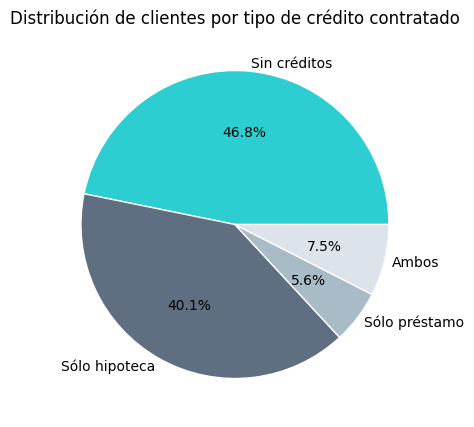

In [81]:
#  3. SALDO MEDIO POR CATEGORÍA DE CRÉDITO
def categorize_credit(row):
    if not row['loan'] and not row['housing']:
        return 'Sin créditos'
    elif not row['loan'] and row['housing']:
        return 'Sólo hipoteca'
    elif row['loan'] and not row['housing']:
        return 'Sólo préstamo'
    else:
        return 'Ambos'

df['categoria_credito'] = df.apply(categorize_credit, axis=1)

balance_promedio = df.groupby('categoria_credito')['balance'].mean()
clientes_por_categoria = df['categoria_credito'].value_counts()
df_balance = pd.DataFrame({
    'categoria_credito': balance_promedio.index,
    'balance_promedio': balance_promedio.values,
    'clientes_por_categoria': clientes_por_categoria[balance_promedio.index].values
})
df_balance['pct_clientes'] = (df_balance['clientes_por_categoria'] / total_clientes * 100).round(1)

orden = ['Sin créditos', 'Sólo hipoteca', 'Sólo préstamo', 'Ambos']
df_balance['categoria_credito'] = pd.Categorical(df_balance['categoria_credito'], categories=orden, ordered=True)
df_balance = df_balance.sort_values('categoria_credito').reset_index(drop=True)

print(df_balance)

# Pie chart de distribución por tipo de crédito
plt.figure(figsize=(5, 5))
plt.pie(
    df_balance['pct_clientes'],
    labels=df_balance['categoria_credito'],
    labeldistance=1.05,
    autopct='%1.1f%%',
    colors=custom_palette,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'}
)
plt.title("Distribución de clientes por tipo de crédito contratado")
plt.show()

In [82]:
#  4. PROBABILIDAD DE INCUMPLIMIENTO (PD) GLOBAL
pd_global = df['default'].mean()
print("PD global =", (pd_global*100).round(2), "%")

PD global = 1.49 %


In [83]:
#  5. ANÁLISIS POR DECILES DE SALDO
df['balance_decile'] = pd.qcut(df['balance'], q=10, labels=False) + 1

default_rates = (
    df.groupby('balance_decile')['default']
    .agg(['mean', 'count'])
    .rename(columns={'mean': 'default', 'count': 'clientes'})
    .reset_index()
)
default_rates['default'] = default_rates['default'].round(4)
default_rates['indice_riesgo'] = (default_rates['default'] / pd_global).round(2)
default_rates['porcentaje_clientes'] = (default_rates['clientes'] / total_clientes * 100).round(2)

def categorize_risk(rate):
    if rate > 0.10:
        return 'Muy alto'
    elif rate > 0.05:
        return 'Alto'
    elif rate > 0.02:
        return 'Moderado'
    return 'Bajo'

default_rates['risk_level'] = default_rates['default'].apply(categorize_risk)

# Porcentaje de clientes por categoría de riesgo
porcentaje_riesgo = (
    default_rates.groupby('risk_level')['porcentaje_clientes']
    .sum()
    .reindex(['Muy alto', 'Alto', 'Moderado', 'Bajo'])
    .fillna(0)
    .reset_index()
)
porcentaje_riesgo['porcentaje_clientes'] = porcentaje_riesgo['porcentaje_clientes'].astype(int)

print(porcentaje_riesgo)

  risk_level  porcentaje_clientes
0   Muy alto                    0
1       Alto                   13
2   Moderado                    6
3       Bajo                   79


## Regresión logística para predicción del default en función del balance
Estimar directamente cómo balance afecta la probabilidad de incumplimiento (default)

In [106]:
# convertir variables binarias
df[['default']].astype(int)

,default
0,0
1,0
2,0
3,0
4,0
...,...
16158,0
16159,0
16160,1
16161,0


In [ ]:
X = df[['balance']]     # predictor
y = df['default']       # objetivo --> variable binaria

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = LogisticRegression()
model.fit(X_train, y_train)

# Coeficientes y el intercepto 
print(model.coef_)
print("Intercepto:", model.intercept_[0])
print("Coeficiente balance:", model.coef_[0][0])

[[-0.0020672]]
Intercepto: -3.498874578863202
Coeficiente balance: -0.002067203063453532


In [ ]:
# Predecir probabilidad en función del saldo --> crear un rango de valores uniforme para ver la variación del default
balances = np.linspace(df['balance'].min(), df['balance'].max(), 1000).reshape(-1, 1)
proba_default = model.predict_proba(balances)[:, 1]

c:\Users\maria\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


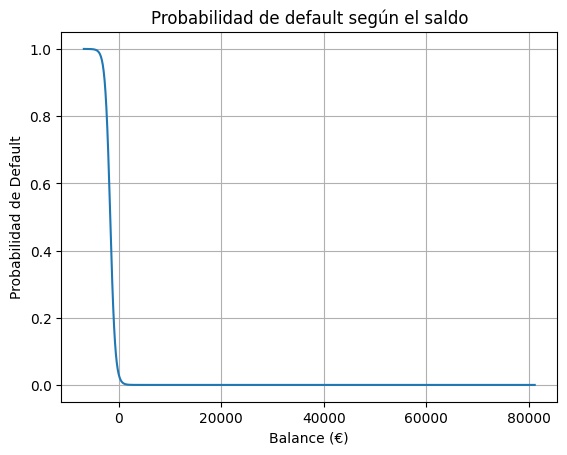

In [ ]:
# Visualizar la curva
plt.plot(balances, proba_default)
plt.xlabel('Balance (€)')
plt.ylabel('Probabilidad de Default')
plt.title('Probabilidad de default según el saldo')
plt.grid()
plt.show()

##### Análisis del resultadi
- La curva muestra una alta probabilidad de default para saldos cercanos o inferiores a 0.
- Cuando el saldo aumenta, la probabilidad baja a 0.
- Confirma que el saldo es un fuerte predictor del riesgo de morosidad

In [99]:
# Saldo a partir del cual la probabilidad de default cae por debajo del 5%:
probab_limite = 0.05
umbral_saldo = balances[proba_default >= probab_limite].max()
print(f"Umbral de riesgo alto: balance < {umbral_saldo:.2f} €")

Umbral de riesgo alto: balance < -324.70 €


## Regresión logística para predicción del default en función de balance, loan y housing
Estimar directamente cómo balance, loan y housing afectan en conjunto a la probabilidad de incumplimiento (default)

In [107]:
# convertir variables binarias
df[['default', 'housing', 'loan']].astype(int)

,default,housing,loan
0,0,1,0
1,0,1,0
2,0,0,0
3,0,1,0
4,0,1,0
...,...,...,...
16158,0,0,0
16159,0,1,0
16160,1,1,0
16161,0,0,0


In [110]:
X = df[['balance', 'housing', 'loan']]     # predictores
y = df['default']       # objetivo --> variable binaria

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo
model = LogisticRegression()
model.fit(X_train, y_train)

# Coeficientes y el intercepto 
print(model.coef_)
print("Intercepto:", model.intercept_[0])
print("Coeficiente balance:", model.coef_[0][0])
print("Coeficiente housing:", model.coef_[0][1])
print("Coeficiente loan:", model.coef_[0][2])

[[-0.00198217 -0.2990674   0.77605341]]
Intercepto: -3.5460227292136697
Coeficiente balance: -0.0019821684994134636
Coeficiente housing: -0.29906740418986516
Coeficiente loan: 0.7760534132715486


#### Sin créditos

c:\Users\maria\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


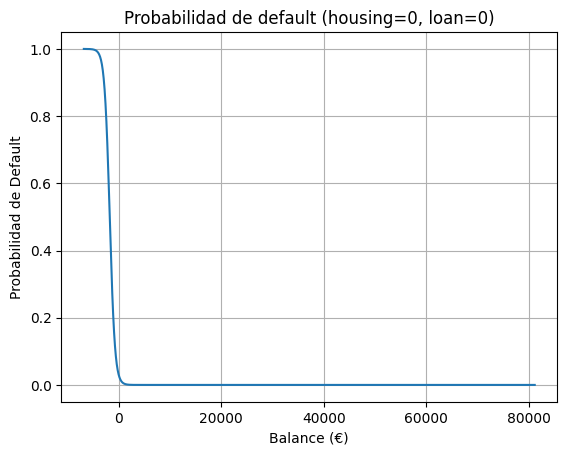

In [116]:
# Predecir probabilidad en función del saldo --> crear un rango de valores uniforme para ver la variación del default
balances_sin = np.linspace(df['balance'].min(), df['balance'].max(), 1000).reshape(-1, 1)
housing_val = np.zeros_like(balances)  # todos 0
loan_val = np.zeros_like(balances)  # todos 0

X_plot = np.hstack([balances, loan_val, housing_val])
proba_default = model.predict_proba(X_plot)[:, 1]

# Visualizar la curva
plt.plot(balances, proba_default)
plt.xlabel('Balance (€)')
plt.ylabel('Probabilidad de Default')
plt.title('Probabilidad de default (housing=0, loan=0)')
plt.grid()
plt.show()

In [118]:
# Saldo a partir del cual la probabilidad de default cae por debajo del 5%:
probab_limite = 0.05
umbral_saldo = balances_sin[proba_default >= probab_limite].max()
print(f"Sin créditos. Umbral de riesgo alto: balance < {umbral_saldo:.2f} €")

Sin créditos. Umbral de riesgo alto: balance < -324.70 €


##### Análisis del resultadi
- La curva muestra una alta probabilidad de default para saldos cercanos o inferiores a 0.
- Cuando el saldo aumenta, la probabilidad baja a 0.
- Confirma que el saldo es un fuerte predictor del riesgo de morosidad

In [105]:
# Saldo a partir del cual la probabilidad de default cae por debajo del 5%:
probab_limite = 0.05
umbral_saldo = balances[proba_default >= probab_limite].max()
print(f"Umbral de riesgo alto: balance < {umbral_saldo:.2f} €")

Umbral de riesgo alto: balance < -324.70 €


## Regresión lineal para ver cómo afectan `housing` y `loan` al `balance`

In [66]:
# Copia de las columnas del df que voy a necesitar
df2 = df[['id','default', 'balance', 'housing', 'loan']].copy()
df2.head()

,id,default,balance,housing,loan
0,1,False,2343,True,False
1,2,False,2343,True,False
2,3,False,45,False,False
3,4,False,1270,True,False
4,5,False,2476,True,False


In [67]:
# Convierto los booleanos a variables binarias
df2[['default', 'housing', 'loan']].astype(int)

,default,housing,loan
0,0,1,0
1,0,1,0
2,0,0,0
3,0,1,0
4,0,1,0
...,...,...,...
16158,0,0,0
16159,0,1,0
16160,1,1,0
16161,0,0,0


In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [69]:
# Definir variables predictoras y objetivo
X = df2[['housing', 'loan']].astype(int)
y = df2['balance']

# Separar datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
model = LinearRegression()
model.fit(X, y)

# Coeficientes
pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_
})

,Variable,Coeficiente
0,housing,-420.579545
1,loan,-791.195527


Cada variable tiene un coeficiente que indica el impacto que tienen sobre la variable dependiente (`balance`).
- Housing: -420,6 €
    > Tener hipoteca se asocia con un saldo anual promedio de unos 420€ menos que no tenerla
- Loan: 791,2 €
    > Tener un préstamos personal se asocia con un saldo anual promedio 791€ menos

In [70]:
from sklearn.metrics import r2_score

y_pred = model.predict(X)
r2_manual = r2_score(y, y_pred)
print(f"R² manual: {r2_manual:.4f}")

R² manual: 0.0127


Del valor de R2 podemos obtener que este modelo solo explica el 1,27% de los datos, pero no explica la estadística

In [71]:
model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                balance   R-squared (uncentered):                   0.064
Model:                            OLS   Adj. R-squared (uncentered):              0.064
Method:                 Least Squares   F-statistic:                              552.3
Date:               ma., 27 may. 2025   Prob (F-statistic):                   9.71e-233
Time:                        11:57:46   Log-Likelihood:                     -1.5417e+05
No. Observations:               16163   AIC:                                  3.083e+05
Df Residuals:                   16161   BIC:                                  3.084e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Prob (F-statistic): si es < 0.05, significa que al menos una variable del modelo es significativa.